In [78]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

# Удовлетворенность пассажиров авиакомпании

Предположим, что вы хотите оценить как зависит довольны ли пассажиры полетом на самолете в зависимости от разных факторов.

## Загружаем данные

Датасет изначально был разделен на тестовую и обучающую выборку. Для чистоты эксперимента не будем пользоваться этим разделением. Объединим обе таблицы и случайным образом перемешаем строки.

In [79]:
data_test = pd.read_csv("./datasets/test.csv")
data_train = pd.read_csv("./datasets/train.csv")
data = pd.concat([data_test, data_train])

In [80]:
data.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [81]:

data.drop(['Unnamed: 0', 'id'], axis=1, inplace=True) # удалим служебные столбцы
data.sample(frac=1, random_state = 42).reset_index(drop=True) # и перемешиваем

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,53,Personal Travel,Business,1096,2,4,2,1,...,2,2,2,4,2,2,5,0,0.0,neutral or dissatisfied
1,Male,Loyal Customer,57,Business travel,Business,224,4,4,4,4,...,5,5,5,5,5,5,5,1,0.0,satisfied
2,Female,Loyal Customer,38,Personal Travel,Eco,630,4,5,4,5,...,2,4,2,5,5,5,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,17,Business travel,Eco Plus,468,4,1,1,1,...,4,5,2,2,2,2,4,0,0.0,satisfied
4,Female,Loyal Customer,48,Business travel,Business,1608,1,1,1,1,...,4,4,4,4,5,4,4,0,19.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,Female,Loyal Customer,10,Personal Travel,Eco,287,2,5,3,3,...,5,4,5,4,1,4,1,127,133.0,neutral or dissatisfied
129876,Female,Loyal Customer,26,Business travel,Business,1601,3,1,3,3,...,3,3,5,4,5,4,3,5,0.0,satisfied
129877,Female,Loyal Customer,57,Business travel,Business,3259,2,5,2,2,...,4,4,4,5,4,4,4,0,0.0,satisfied
129878,Female,Loyal Customer,13,Personal Travel,Eco,441,3,4,3,2,...,5,5,5,3,4,3,5,13,0.0,neutral or dissatisfied


In [82]:
data.columns

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

Столбцы (признаки) имеют имена

- `Gender` - Пол. Бинарный признак. Типы: Female (Женский), Male (Мужской).
- `Customer Type` - Тип клиента. Бинарный признак. Типы: `Loyal customer` (Лояльный клиент) и `Disloyal customer` (Нелояльный клиент). Лояльный клиент - это клиент, лояльный к авиакомпании, то есть чаще предпочитающий пользоваться услугами данной авиакомпании нежели другой. Нелояльный - чаще пользующийся услугами другой компании.
- `Age` - Возраст. Количественный признак.
- `Type of Travel` - Цель полета пассажира. Бинарный признак. Типы: `Personal Travel` (Личная поездка), Business Travel (Деловая поездка).
- `Class` - Туристический класс, которым летит пассажир. Категориальный признак. Типы: `Business` (Бизнес), `Eco` (Эконом), `Eco Plus` (Эконом Плюс).
- `Flight Distance` - Расстояние полета. Количественный признак.
- `Inflight wifi service` - уровень удовлетворенности услугой Wi-Fi - от 1 до 5.  Количественный признак.
- `Departure/Arrival time convenient` - Уровень удовлетворенности тем, насколько удобно было время отправления/прибытия. Количественный признак.
- `Ease of Online booking` - Уровень удовлетворенности простотой онлайн-бронирования. Количественный признак.
- `Gate location` - Уровень удовлетворенности расположением выходов. Количественный признак.
- `Food and drink` - Уровень удовлетворенности едой и напитками. Количественный признак.
- `Online boarding` - Уровень удовлетворенности онлайн регистрацией на рейс. Количественный признак.
- `Seat comfort` - Уровень удовлетворенности комфортабельностью кресел. Количественный признак.
- `Inflight entertainment` - Уровень удовлетворенности развлечениями во время полета. Количественный признак.
- `On-board service` - Уровень удовлетворенности услугами на борту. Количественный признак.
- `Leg room service` - Уровень удовлетворенности количеством места для ног. Количественный признак.
- `Baggage handling` - Уровень удовлетворенности услугами по транспортировке багажа. Количественный признак.
- `Checkin service` - Уровень удовлетворенности услугой регистрации на рейс. Количественный признак.
- `Inflight service` - Уровень удовлетворенности услугами во время полета. Количественный признак.
- `Cleanliness` - Уровень удовлетворенности чистотой. Количественный признак.
- `Departure Delay in Minutes` - Задержка отправления в минутах. Количественный признак.
- `Arrival Delay in Minutes` - Задержка прибытия в минутах. Количественный признак.
- `satisfaction` - Уровень удовлетворенности. Категориальный признак. Типы: `Satisfaction` (Удовлетоврен), `neutral` (Нейтрально) or `dissatisfaction` (Неудовлетоврен).

Требуется предсказать признак `satisfaction` по остальным признакам. Это *задача классификации*.

##  Обрабатываем пропущенные значения

В данных небошльшое количество пропущенных значений:

In [83]:
data.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам:

In [84]:
data['Arrival Delay in Minutes'].fillna(data['Arrival Delay in Minutes'].median(axis = 0), axis=0 , inplace=True)

In [85]:
data.isna().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

## Боремся с выбросами для числовых признаков

In [65]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']
['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


In [66]:
print(data.shape)

rows_to_drop = []
for column in data.columns:
    if (column in categorical_columns):
        continue
    rows_to_drop += data[(data[column] < data[column].quantile(0.005))
    | (data[column] > data[column].quantile(0.995))].index.tolist()
data = data.drop(rows_to_drop)

print(data.shape)

(129880, 23)
(125523, 23)


Для всех количественных признаков удаление выбросов привело к сокращению количества строк на 129880 - 125523 = 4357 строк

## Визуализация и описательная статистика

Матрица корреляции

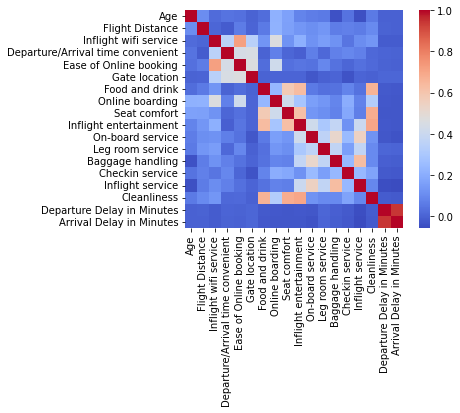

In [67]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

In [68]:
data.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,125523.000000,125523.000000,125523.000000,125523.000000,125523.000000,125523.000000,125523.000000,125523.00000,125523.000000,125523.000000,125523.000000,125523.000000,125523.000000,125523.000000,125523.000000,125523.000000,125523.000000,125148.000000
mean,39.184675,1181.377636,2.736287,3.058906,2.770162,2.975925,3.208790,3.25005,3.440509,3.360277,3.387220,3.364356,3.635891,3.309003,3.650701,3.287334,13.000191,13.359095
std,14.929654,977.258878,1.324943,1.524559,1.389341,1.278456,1.327188,1.35219,1.321571,1.334080,1.285096,1.300291,1.177587,1.265095,1.171813,1.313939,28.879849,29.245656
min,7.000000,86.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,27.000000,417.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1730.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,72.000000,3944.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,232.000000,235.000000


Пропущенные значения в столбцах, соответствующих категориальным признакам, заполним модой:

In [ ]:
for c in categorical_columns:
    data[c].fillna(data[c].mode().iloc[0], inplace=True)

In [ ]:
data.isna().sum()

## Векторизация

Обработка категориальных признаков

In [ ]:
data_describe = data.describe(include = [object])
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

In [ ]:
data['RainToday'].unique()

In [ ]:
data.at[data['RainToday'] == 'No', 'RainToday'] = 0
data.at[data['RainToday'] == 'Yes', 'RainToday'] = 1
data['RainToday'].describe()

К небинарными признакам применим метод _векторизации_, 
который заключается в следующем.

Признак `j`, принимающий `s` значений, заменим на `s` признаков, принимащих значения `0` или `1`,
в зависимости от того, чему равно значение исходного признака `j`.

In [ ]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

## Нормализация количественных признаков

Многие алгоритмы машинного обучения чувствительны к масштабированию данных.
К таким алгоритмам, например, относится метод ближайших соседей, машина опорных векторов и др.

В этом случае количественные признаки полезно _нормализовать_.
Это можно делать разными способами.
Например, каждый количественный признак приведем к нулевому среднему и единичному среднеквадратичному отклонению:

In [ ]:
data_numerical = data[numerical_columns]
data_numerical.describe()

In [ ]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

## Соединяем все в одну таблицу

In [ ]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)

## 7. Разбиение данных на обучающую и тестовую выборки

Для предсказания будем использовать все признаки.

In [ ]:
X = data.drop('RainTomorrow', axis = 1)
y = data['RainTomorrow']

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

## Классификатор ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

In [ ]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)

In [ ]:
err_train

In [ ]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)

In [ ]:
err_test

Ошибка на обучающей выборке меньше из-за так называемого переобучения. На определенных данных алгоритм улавливает какие-то случайные закономерности, свойственные только конкретному набору данных, и используя их, ошибается меньше.

Матрица рассогласования:

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
pass

Тру негативов больше чем тру позитивов, из-за несбалансированности классов. В `RainTomorrow` No составляет 78%, Yes - 22%

### Увеличим количество ближайших соседей до 9

In [ ]:
knn.set_params(n_neighbors=9)
knn.fit(X_train, y_train)

In [ ]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

In [ ]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

### Увеличим количество ближайших соседей до 17

In [ ]:
knn.set_params(n_neighbors=17)
knn.fit(X_train, y_train)

In [ ]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

In [ ]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

### Увеличим количество ближайших соседей до 51

In [ ]:
knn.set_params(n_neighbors=51)
knn.fit(X_train, y_train)

In [ ]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

In [ ]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

### Подбор параметров

In [ ]:
# Долго!
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 9, 15, 19, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

Наиболее эффективен метод с 19-ю ближайшими соседями, хотя вероятности для разного числа соседей на тестовой выборке примерно одинаковы.